In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, roc_auc_score, mean_absolute_error
import joblib


# Data Loading

In [2]:
data = pd.read_csv("Symptom2Disease.csv")
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (1200, 3)


,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


# Data preprocessing

In [5]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words

if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)
data['clean_text'] = data['text'].apply(clean_text)
print(data[['text','clean_text']].head())



                                                text  \
0  I have been experiencing a skin rash on my arm...   
1  My skin has been peeling, especially on my kne...   
2  I have been experiencing joint pain in my fing...   
3  There is a silver like dusting on my skin, esp...   
4  My nails have small dents or pits in them, and...   

                                          clean_text  
0  experiencing skin rash arms legs torso past we...  
1  skin peeling especially knees elbows scalp pee...  
2  experiencing joint pain fingers wrists knees p...  
3  silver like dusting skin especially lower scal...  
4  nails small dents pits feel inflammatory tende...  


# EDA

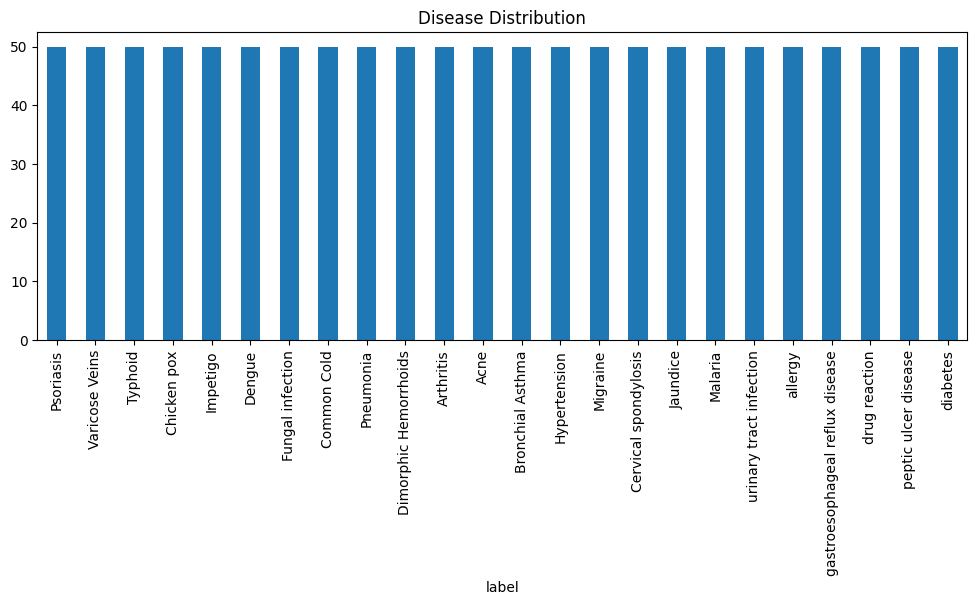

In [6]:

data['label'].value_counts().plot(kind='bar', figsize=(12,4))
plt.title("Disease Distribution")
plt.show()


# Feature Engineering

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = data['clean_text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Shape:", X_train_tfidf.shape)


TF-IDF Shape: (960, 7791)


# Model Building

In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500)
clf.fit(X_train_tfidf, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


# Model Evaluation

In [9]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

y_pred = clf.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9458333333333333
Macro F1: 0.9447052547991435

Classification Report:
                                  precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       0.91      1.00      0.95        10
               Bronchial Asthma       0.91      1.00      0.95        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       0.80      0.80      0.80        10
                    Common Cold       1.00      1.00      1.00        10
                         Dengue       0.80      0.80      0.80        10
          Dimorphic Hemorrhoids       1.00      1.00      1.00        10
               Fungal infection       1.00      1.00      1.00        10
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       1.00      1.00      1.00        10
                       Jaundice       1.

# Model Saving

In [10]:
import joblib

joblib.dump(clf, "text_clf_model.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")


['tfidf_vectorizer.joblib']

# Export Predictions for Dashboard

In [11]:
pred_df = pd.DataFrame({"text": X_test, "actual": y_test, "predicted": y_pred})
pred_df.to_csv("predictions_for_dashboard.csv", index=False)
pred_df.head()


,text,actual,predicted
408,ive experiencing chills feel really exhausted ...,Pneumonia,Pneumonia
856,ive intense itching body accompanied chills vo...,Malaria,Malaria
285,feeling extremely tired fatigued energy fatigu...,Dengue,Chicken pox
484,im having lot trouble bowel movements lately h...,Dimorphic Hemorrhoids,Dimorphic Hemorrhoids
543,neck tight muscles felt quite weak recently to...,Arthritis,Arthritis
